In [193]:
import sklearn 
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

# 1. Data Preparation

In [194]:
# Helper functions
def clean_text(text, remove_nums = True):
  if remove_nums:
    # Remove all numbers 
    result = re.sub(r'[0-9\.]+','', text)
    # lowercase and symbols
    return ''.join([char.lower() for char in result if char.isalnum() or char.isspace()])
  else:
    return ''.join([char.lower() for char in text if char.isalnum() or char.isspace()])

def lemmatize_text(text, lemmatizer):
  # lemmatization options
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def preprocessing_texts(df, column_name, apply_lemmatization, lemmatizer):
    texts = df[column_name].apply(clean_text)
    if apply_lemmatization:
        texts = texts.apply(lambda x: lemmatize_text(x, lemmatizer))
    return texts


def vectorize_datasets(train_df, test_df, vectorizer_type='count', ngram_range=(1, 1), remove_stopwords=False, apply_lemmatization=False):
    # Vectorizes the datasets with the preprocessing pipeline with options control
    lemmatizer = WordNetLemmatizer() if apply_lemmatization else None
    stop_words = 'english' if remove_stopwords else None

    # Option 1: Choose Vectorizer and Bag-Of-Words
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram_range)
    else:
        raise ValueError("Invalid vectorizer type")

    # Option 2: Clean text and lemmization
    train_texts = preprocessing_texts(df=train_df, column_name='content', apply_lemmatization=apply_lemmatization, lemmatizer=lemmatizer)
    test_texts = preprocessing_texts(df=test_df, column_name='content', apply_lemmatization=apply_lemmatization, lemmatizer=lemmatizer)

    train_vectors = vectorizer.fit_transform(train_texts)
    test_vectors = vectorizer.transform(test_texts)

    # Extract the y column
    y_train = train_df['topic open coding 3']
    y_test = test_df['topic open coding 3']

    return train_vectors, test_vectors, y_train, y_test, vectorizer

def bleaching(textdf):
    # Uses the clean_text() function to completely sanitize the text inside a pandas dataframe 
    # Done in two assignments to avoid the SettingWithCopyWarning
    for idx in textdf.index:
        cleaned_text = clean_text(textdf.loc[idx, 'content'], remove_nums = True)
        textdf.loc[idx, 'content'] = cleaned_text
    return textdf 


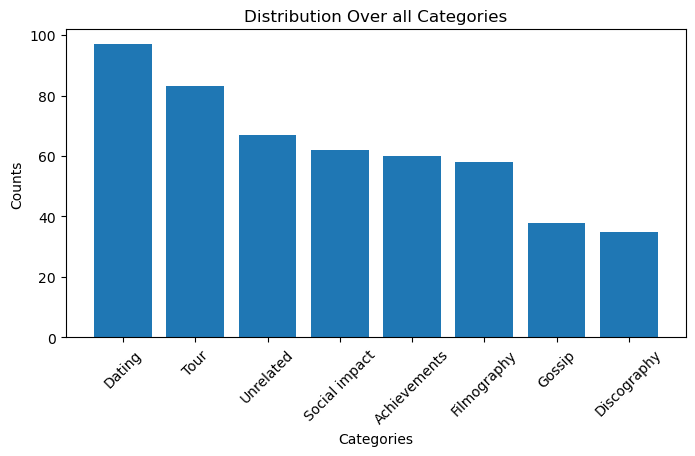

In [195]:
# Data Initialization (Careful sampling for representative training data)
df = pd.read_csv('./annotation_swift_data.csv')

# Display the distribution of categories
category_counts = df['topic open coding 3'].value_counts()
fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.bar(category_counts.index, category_counts)
ax.set_xticks(category_counts.index)
ax.set_xticklabels(category_counts.index, rotation = 45)
ax.set_ylabel('Counts')
ax.set_xlabel('Categories')
ax.set_title("Distribution Over all Categories")

# Do stratified sampling
sampled_data = df.groupby('topic open coding 3').apply(lambda x: x.sample(min(len(x), min(category_counts)), random_state=42)).reset_index(drop=True)
excluded_data = df.drop(sampled_data['Unnamed: 0']) # We'll use this after training is done

In [196]:
# Data cleaning for training set 
df = sampled_data[['content','topic open coding 3','sentiment open coding']].copy()
train_inputdf = bleaching(df)
traindf, _ = train_test_split(train_inputdf, train_size = 1-1e-10, random_state = 42)

# Data cleaning for test set 
df = excluded_data[['content','topic open coding 3','sentiment open coding']].copy()
test_inputdf = bleaching(df)
pred, testdf = train_test_split(test_inputdf, test_size = 0.5, random_state = 42)

# Encode the category labels
encode = {}
for idx, category in enumerate(np.unique(df['topic open coding 3'])):
    encode[category] = idx + 1

for idx in df.index:
    df.loc[idx, 'topic open coding 3'] = encode[df.loc[idx, 'topic open coding 3']]

# In case we need to decode the categories
decode = {}
for idx, key in enumerate(encode.keys()):
    decode[idx+1] = key

# 2. Model Coding

In [197]:
# Multinomial Likelihood Naive Bayes Model 
class NaiveBayes:
    def __init__(self, laplace=1):
        # Freely change the laplace factor when building the model
        self.laplace = laplace

    def fit(self, X, Y):
        # Initialization
        n_docs, n_features = X.shape
        self.classes = np.unique(Y)
        n_classes = len(self.classes)

        # Prior and posterior parameters
        self.class_log_prior = np.zeros(n_classes)
        self.feature_log_post = np.zeros((n_classes, n_features))

        # Learning process using Laplace prior and multinomial likelihood
        for i, cls in enumerate(self.classes):
            X_cls = X[Y == cls]
            self.class_log_prior[i] = np.log(X_cls.shape[0] / n_docs)
            total_count = np.sum(X_cls, axis=0) + self.laplace
            # Possible Improvement
            # P(word|class) = (Count(word, class) + laplace)/(Count(word) + Count(unique_word)*laplace) ## same
            # self.feature_log_post[i, :] = np.log(total_count / (np.sum(total_count))
            self.feature_log_post[i, :] = np.log(total_count / (np.sum(X_cls) + n_features * self.laplace))

    def predict(self, X):
        log_probs = X @ self.feature_log_post.T + self.class_log_prior
        # Possible Improvement
        # np.argmax(log_probs, axis=1)
        return self.classes[np.argmax(log_probs, axis=1)]

    def eval(self, X, Y):
        y_pred = self.predict(X)
        return np.mean(y_pred == Y)

# 3. Running the Model

In [198]:
# Vectorize the dataset 
Xtrain, Xtest, ytrain, ytest, vectorizer = vectorize_datasets(
    train_df=traindf,
    test_df=testdf,
    vectorizer_type='count',  # Vectorizer Options: 'count'/ 'tfidf'
    ngram_range=(1,2),  # Bag-Of-Words Options
    remove_stopwords=True, # Stop Word Removal Options
    apply_lemmatization=True  # Lemmatization Options
)

Manual implementation accuracy = 0.709091 with Lidstone smoothing parameter = 0.795918
Sklearn implementation accuracy: 0.709091


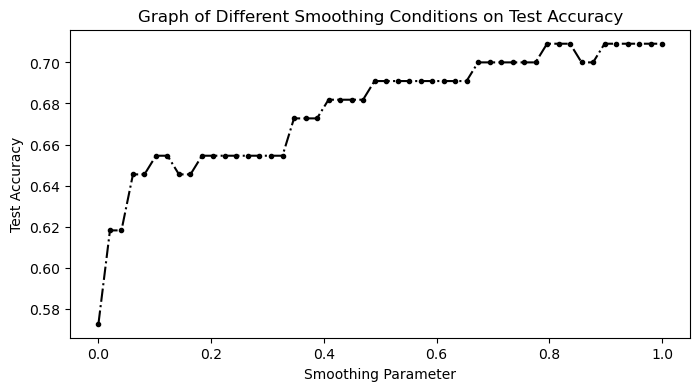

In [199]:
# Manual implementation of Naive Bayes
x = np.linspace(1e-13, 1, 50)
y = []

for val in x:
    model = NaiveBayes(laplace = val)
    model.fit(Xtrain, ytrain)
    y.append(model.eval(Xtest, ytest))

fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(x, y, 'k.-.')
ax.set_xlabel('Smoothing Parameter')
ax.set_ylabel('Test Accuracy')
ax.set_title('Graph of Different Smoothing Conditions on Test Accuracy')

best_acc = max(y)
best_param = x[np.argmax(y)]
print(f"Manual implementation accuracy = %f with Lidstone smoothing parameter = %f" % (best_acc, best_param))

# Sklearn implementation of Naive Bayes 
from sklearn.naive_bayes import MultinomialNB

# Do Multinomial classification 
nb_classifier = MultinomialNB()
nb_classifier.fit(Xtrain.toarray(), list(ytrain))
test_predictions = nb_classifier.predict(Xtest.toarray())

# Calculate accuracy on the test set
print(f"Sklearn implementation accuracy: %f" % (np.mean(ytest == test_predictions)))

In [200]:
# Interpolation (using previously unseen data in either training or testing)
Xtrain, Xtest, ytrain, ytest, vectorizer = vectorize_datasets(
    train_df=traindf,
    test_df=pred,
    vectorizer_type='count',  # Vectorizer Options: 'count'/ 'tfidf'
    ngram_range=(1,2),  # Bag-Of-Words Options
    remove_stopwords=True, # Stop Word Removal Options
    apply_lemmatization=True  # Lemmatization Options
)

# Use the previously found best parameter 
# Interpolate on entries we haven't yet used
model.laplace = best_param
out = model.predict(Xtest)

# add new column to dataframe and output as csv 
pred['pred'] = out 
pred.to_csv('./predictions.csv')

C:\Users\yuhao\AppData\Local\Temp\ipykernel_10548\3972779984.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['pred'] = out
